# A computational account of threat-related attentional bias

# Parameter recovery tests

In [1]:
import os
import sys
sys.path.insert(0, '../code') 
import pymc3 as pm
import pandas as pd
import numpy as np
import os
from DMpy import DMModel, Parameter
from DMpy.utils import beta_response_transform
from modelling_functions import combine_behavioural, save_simulated, plot_param_values
from learning_models import leaky_beta_asymmetric, leaky_beta_asymmetric_fixation_2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
import pandas as pd
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Random seed
np.random.seed(123)


Here we will check that we can recover values of the free parameters in our best-fitting models accurately. To do this, we generate simulated datasets using the outcomes from the task across a realistic range of parameter values. We then fit our models to this data and evaluate how well the recovered parameter values match those used to generate the data.

## Load data

We'll load the true data just to get the task outcomes

In [2]:
data = pd.read_csv('et_behav_data.csv')
data = data[:312]
data.head()
data.to_csv('simulation_data.csv', index=False)

## Leaky beta model

This was our initial best-fitting behavioural model.

### Set up the model

In [3]:
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)

# Parameters of beta distribution - starting values fixed at 1
alpha = Parameter('alpha', 'fixed', mean=1, dynamic=True)
beta = Parameter('beta', 'fixed', mean=1, dynamic=True)

# Decay rate, normally distributed between 0 and 1
decay = Parameter(r'$\lambda$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Positive and negative weights for the asymmetric model, normally distributed between 0 and 1
tau_p = Parameter(r'$\tau^+$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)
tau_n = Parameter(r'$\tau^-$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Influence of the other stimulus, normally distributed between 0 and 1
omega = Parameter(r'$\omega$', 'normal', lower_bound=0, upper_bound=0.5, mean=0, variance=5)

leaky_beta_asymmetric_model = DMModel(leaky_beta_asymmetric, [value, alpha, alpha, decay, omega, tau_p, tau_n], None, None,
                               name='Asymmetric leaky beta', logp_function='beta')

### Simulate data

In [4]:
n_subjects = 100

value_sim_values = np.array([0.5] * n_subjects)
alpha_sim_values = np.array([1] * n_subjects)
decay_sim_values = np.random.random(n_subjects)  
tau_p_sim_values = np.random.random(n_subjects)
tau_n_sim_values = np.random.random(n_subjects)
omega_sim_values = np.random.random(n_subjects) * 0.5

In [5]:
sim_results, _ = leaky_beta_asymmetric_model.simulate('simulation_data.csv', learning_parameters={'value': value_sim_values, 
                                                                                         'alpha': alpha_sim_values, 'beta': alpha_sim_values,
                                                                                         '$\lambda$': decay_sim_values,
                                                                                         '$\omega$': omega_sim_values,
                                                                                     '$\\tau^+$': tau_p_sim_values, 
                                                                                     '$\\tau^-$': tau_n_sim_values}, response_variable='value', combinations=False, model_inputs=['Outcome_2'])

Simulating data from 800 sets of parameter values


c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1114: Warning: Fewer outcome lists than simulated subjects, attempting to use same outcomes for each subject (number of outcome lists = 39, number of subjects = 800
  p_combinations.shape[0]), Warning)


Saving simulated results to 


### Fit the model to simulated data

Here we're going to use some relatively basic model fitting methods for speed - if parameter recovery looks with with maximum likelihood estimation (MLE) we can assume it'll probably be fine with anything more complicated!

Loading multi-subject data with 100 subjects, 8 runs per subject
Loaded data, 100 subjects with 39 trials * 8 runs

Parameter $\lambda$ distribution is normal, converting to uniform with bounds (0, 1) for MLE

Parameter $\omega$ distribution is normal, converting to uniform with bounds (0, 0.5) for MLE

Parameter $\tau^+$ distribution is normal, converting to uniform with bounds (0, 1) for MLE

Parameter $\tau^-$ distribution is normal, converting to uniform with bounds (0, 1) for MLE
Created model

-------------------Finding MLE estimate-------------------

Performing model fitting for 100 subjects


logp = 2.3351e+05, ||grad|| = 357.69: 100%|████████████████████████████████████████| 2256/2256 [00:57<00:00, 39.26it/s]


Performing parameter recovery tests...


C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


calculating fit stats
Model likelihood = 233505.697432, BIC = nan, AIC = -466011.394865
Finished model fitting in 80.4289694254 seconds


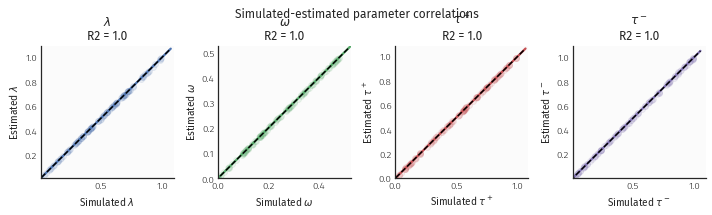

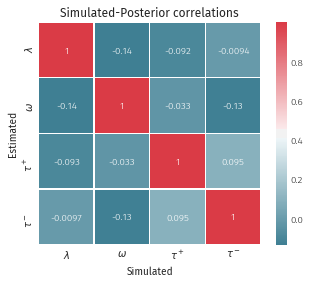

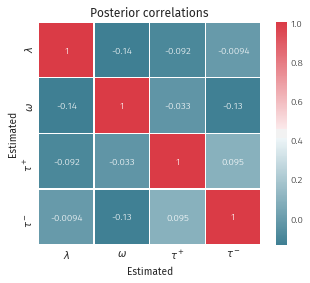

In [6]:
leaky_beta_asymmetric_model.fit(sim_results.results, fit_method='MLE', suppress_table=True, recovery=True, hierarchical=False, model_inputs=['sim_model_input_0'],
          plot=False, response_transform=beta_response_transform)

## Leaky beta model + fixation influence (Model 1)

This model incorporates the influence of fixation duration on the previous trial on probability estimates. For simulation we'll use real fixation values from the first subject - the actual value of these shouldn't matter so it's not a problem to use real data, we're simply interested in whether we can recover the value of the parameter that affects how these values are used.

In [7]:
theta = Parameter(r'$\theta$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

leaky_beta_asymmetric_fixation_2_model = DMModel(leaky_beta_asymmetric_fixation_2, [value, alpha, beta, decay, omega, tau_p, tau_n, theta], None, None,
                               name='Asymmetric forgetful beta + fixation (6b)', logp_function='beta')


In [8]:
theta_sim_values = np.random.random(n_subjects)

In [9]:
sim_results, _ = leaky_beta_asymmetric_fixation_2_model.simulate('simulation_data.csv', learning_parameters={'value': value_sim_values, 
                                                                                         'alpha': alpha_sim_values, 'beta': alpha_sim_values,
                                                                                         '$\lambda$': decay_sim_values,
                                                                                         '$\omega$': omega_sim_values,
                                                                                     '$\\tau^+$': tau_p_sim_values, 
                                                                                     '$\\tau^-$': tau_n_sim_values,
                                                                                    r'$\theta$': theta_sim_values}, response_variable='value', combinations=False, 
                                                          model_inputs=['Outcome_2', 'fixation_proportion_A', 'fixation_proportion_B'])

Simulating data from 800 sets of parameter values
Saving simulated results to 


Loading multi-subject data with 100 subjects, 8 runs per subject
Loaded data, 100 subjects with 39 trials * 8 runs
Created model

-------------------Finding MLE estimate-------------------

Performing model fitting for 100 subjects


logp = 2.5937e+05, ||grad|| = 2,750.3: : 5001it [02:48, 29.60it/s]



Performing parameter recovery tests...
calculating fit stats
Model likelihood = 259374.647138, BIC = nan, AIC = -517549.294277
Finished model fitting in 226.241284536 seconds


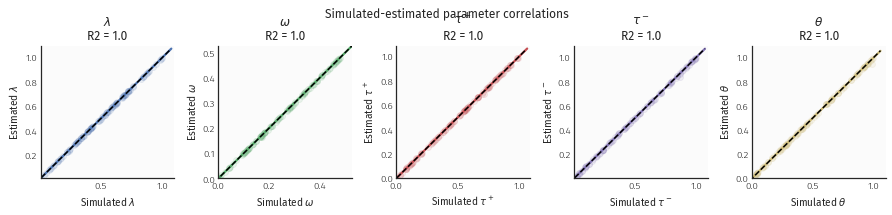

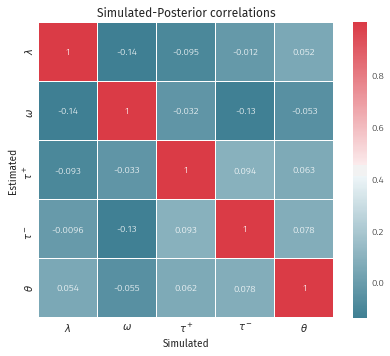

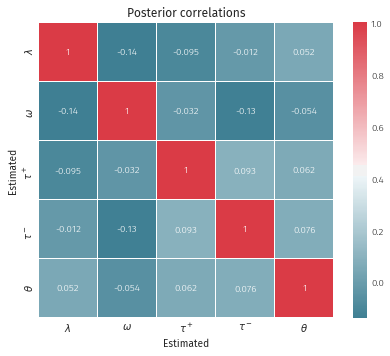

In [11]:
leaky_beta_asymmetric_fixation_2_model.fit(sim_results.results, fit_method='mle', suppress_table=True, recovery=True, hierarchical=True, 
                                               model_inputs=['sim_model_input_0', 'sim_model_input_1', 'sim_model_input_2'], 
          plot=False, response_transform=beta_response_transform)